In [1]:
# A couple requried imports
from glob import glob 
import numpy as np
from matplotlib import pyplot as plt
import os
import urllib
import zipfile
from glob import glob

from tifffile import imread

# Importing the deep learning framework
from csbdeep.models import CARE, Config

from csbdeep.utils import plot_some, plot_history

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

2021-11-10 10:57:39.814934: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# CSBDeep & Noise2Noise
We use the [CSBDeep](http://csbdeep.bioimagecomputing.com/) training framework which was published with [CARE](https://www.nature.com/articles/s41592-018-0216-7). Furthermore we use the [Noise2Noise](https://arxiv.org/abs/1803.04189) training principle first described by Lehtinen _et al._

Noise2Noise states that multiple noisy observation are sufficient to train content aware image restoration networks. In other words, no ground truth data is required. This opens the door to many new applications where the acquisition of ground truth data is impossible or very time consuming. 

In this example we will train a content aware image restoration network with multiple fast scanned noisy Scanning Electron Microscopy (SEM) images. 

# Download Example Data

Data by Reza Shahidi and Gaspar Jekely, Living Systems Institute, Exeter
Thanks!

In [2]:
# create a folder for our data.
if not os.path.isdir('./data'):
    os.mkdir('./data')

# check if data has been downloaded already
zipPath="data/SEM.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://download.fht.org/jug/n2n_sem_data/n2n_sem_data.zip', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

# Load Training Data
We have a stack of seven Scanning Electron Microscopy (SEM) images acquired over a range of different scanning speeds. The faster a SEM image is scanned, the noisyer it gets.

In [3]:
# Load the SEM stack 
train_imgs = np.moveaxis(imread('data/SEM/train/train.tif'), 0, -1)
print(train_imgs.shape)

(2971, 1690, 7)


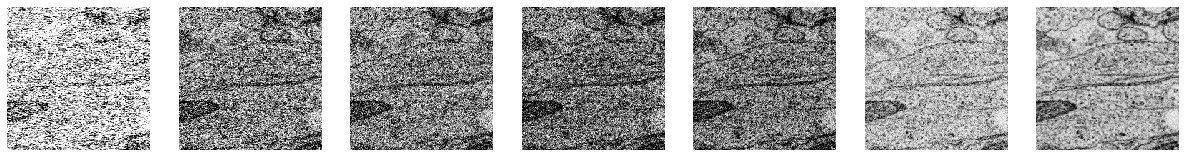

In [4]:
plt.figure(figsize=(21,3))
for i in range(train_imgs.shape[-1]):
    plt.subplot(1,7,i+1)
    plt.imshow(train_imgs[1400:1600,400:600,i], cmap='gray_r', interpolation='nearest')
    plt.axis('off')

__Note:__ These images are already aligned. If you acquire your own noisy data by scanning a sample multiple times you have to check the alignment and register them. 

## Patch Generation
Now we have to extract training patches from the large SEM images.

In [5]:
def get_patches(img, shape=(128, 128)):
    patches = []
    for y in range(0, img.shape[0]-shape[0], shape[0]):
        for x in range(0, img.shape[1]-shape[1], shape[1]):
            patches.append(img[y:y+shape[0], x:x+shape[0]])
    
    return np.array(patches)

In [6]:
# Extract 128x128 patches from all seven noisy images
patches = get_patches(train_imgs)

np.random.shuffle(patches)
train_patches = patches[:270]
val_patches = patches[270:]

print(train_patches.shape)
print(val_patches.shape)

(270, 128, 128, 7)
(29, 128, 128, 7)


Now we assemble `X`, `Y`, `X_val` and `Y_val`.

In [7]:
X = []
Y = []
for patch in train_patches:
    for i in range(7):
        for j in range(7):
            if i != j:
                X.append(patch[...,i])
                Y.append(patch[...,j])
                
X = np.array(X)[...,np.newaxis]
Y = np.array(Y)[...,np.newaxis]

In [8]:
X_val = []
Y_val = []
for patch in val_patches:
    for i in range(7):
        for j in range(7):
            if i != j:
                X_val.append(patch[...,i])
                Y_val.append(patch[...,j])
                
X_val = np.array(X_val)[...,np.newaxis]
Y_val = np.array(Y_val)[...,np.newaxis]

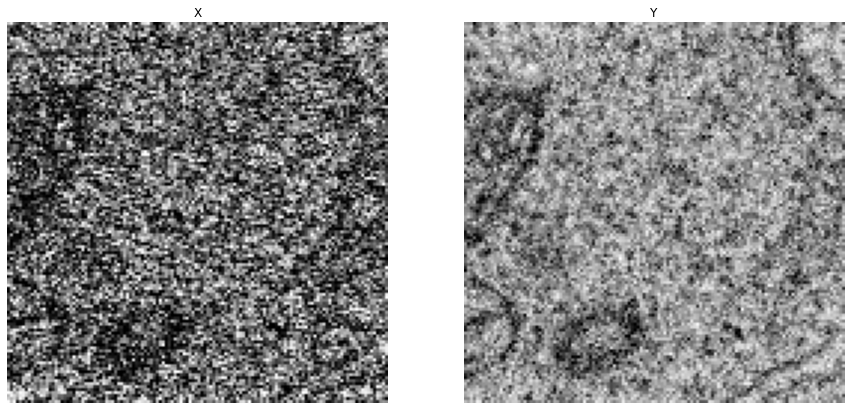

In [9]:
# Look at some patches
idx = 10
plt.figure(figsize=(15,7.5))
plt.subplot(1,2,1)
plt.imshow(X[idx,...,0], cmap='gray_r')
plt.axis('off');
plt.title('X');
plt.subplot(1,2,2)
plt.imshow(Y[idx,...,0], cmap='gray_r')
plt.axis('off');
plt.title('Y');
plt.show()

## Create and Train the Network

In [10]:
# Check train- and val-patches shapes
print(X.shape, Y.shape)
print(X_val.shape, Y_val.shape)

(11340, 128, 128, 1) (11340, 128, 128, 1)
(1218, 128, 128, 1) (1218, 128, 128, 1)


In [11]:
# Now we normalize the data to 0 mean and 1 standard deviation.
mean = np.mean(np.concatenate([X, Y], axis=-1))
std = np.std(np.concatenate([X, Y], axis=-1))

In [12]:
def normalize(data, mean, std):
    return (data - mean)/std

In [13]:
X = normalize(X, mean, std)
Y = normalize(Y, mean, std)
X_val = normalize(X_val, mean, std)
Y_val = normalize(Y_val, mean, std)

In [14]:
# Note: You want to increase train_epochs to something around 100-200.
config = Config(axes='YXC', n_channel_in=1, n_channel_out=1, train_loss='mse', unet_kern_size=3,
               train_steps_per_epoch=200, train_epochs=30)
vars(config)

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 30,
 'train_steps_per_epoch': 200,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [15]:
# Here we create a new model, which is called exmaple_model and stored in the directory 'models'.
model = CARE(config, name='N2N_SEM', basedir='models')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/home/tbuchhol/Programs/miniconda3/envs/n2n_sem/lib/python3.7/site-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /home/tbuchhol/Gitrepos/Astronomy_Denoising/models/N2N_SEM
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [16]:
history = model.train(X, Y, (X_val, Y_val))


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/30
200/200 [==============================] - 12s 58ms/step - loss: 0.7557 - mse: 0.7558 - mae: 0.7035 - val_loss: 0.6995 - val_mse: 0.6995 - val_mae: 0.6763

Epoch 2/30
200/200 [==============================] - 9s 43ms/step - loss: 0.6921 - mse: 0.6921 - mae: 0.6753 - val_loss: 0.6760 - val_mse: 0.6760 - val_mae: 0.6664
Epoch 3/30
200/200 [==============================] - 9s 43ms/step - loss: 0.6503 - mse: 0.6503 - mae: 0.6504 - val_loss: 0.6158 - val_mse: 0.6158 - val_mae: 0.6290
Epoch 4/30
200/200 [==============================] - 9s 43ms/step - loss: 0.6414 - mse: 0.6414 - mae: 0.6438 - val_loss: 0.6289 - val_

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


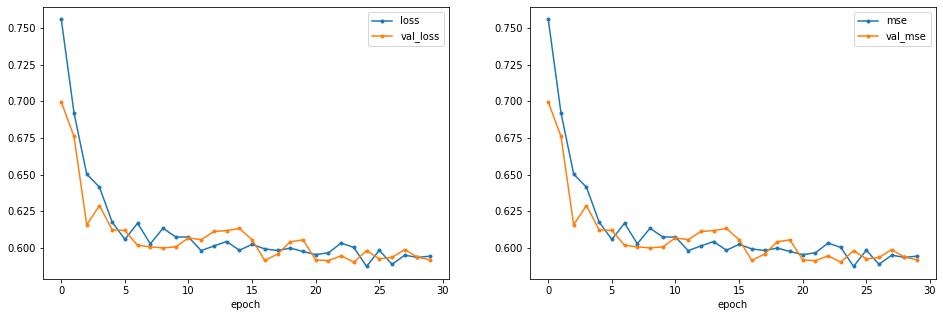

In [17]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse']);

## Predict

In [18]:
def denormalize(img, mean, std):
    return (img * std) + mean

In [19]:
test_imgs = imread('data/SEM/test/test.tif')
print(test_imgs.shape)

(7, 2959, 1666)


In [20]:
test_denoised = []
for img in test_imgs:
    test_denoised.append(denormalize(model.predict(normalize(img, mean, std), 'YX', normalizer=None), mean, std))

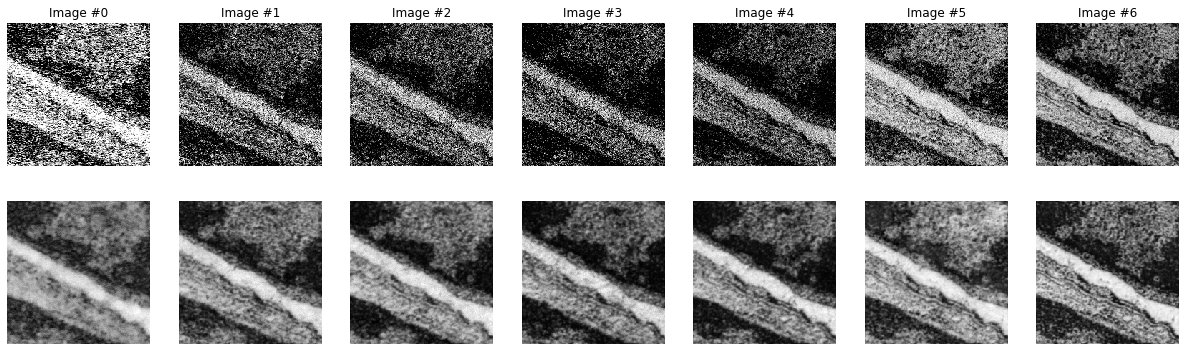

In [21]:
plt.figure(figsize=(21,6))
for i in range(train_imgs.shape[-1]):
    plt.subplot(2,7,i+1)
    plt.imshow(test_imgs[i][1400:1600,400:600], cmap='gray_r', interpolation='nearest')
    plt.axis('off')
    plt.title('Image #{}'.format(i));
for i in range(train_imgs.shape[-1]):
    plt.subplot(2,7,i+8)
    plt.imshow(test_denoised[i][1400:1600,400:600], cmap='gray_r', interpolation='nearest')
    plt.axis('off')

In [22]:
# We can create a ground truth (GT) image by averaging over all noisy images
# But keep in mind, that this GT is still 'noisy'.
gt = np.mean(test_imgs, axis=0)

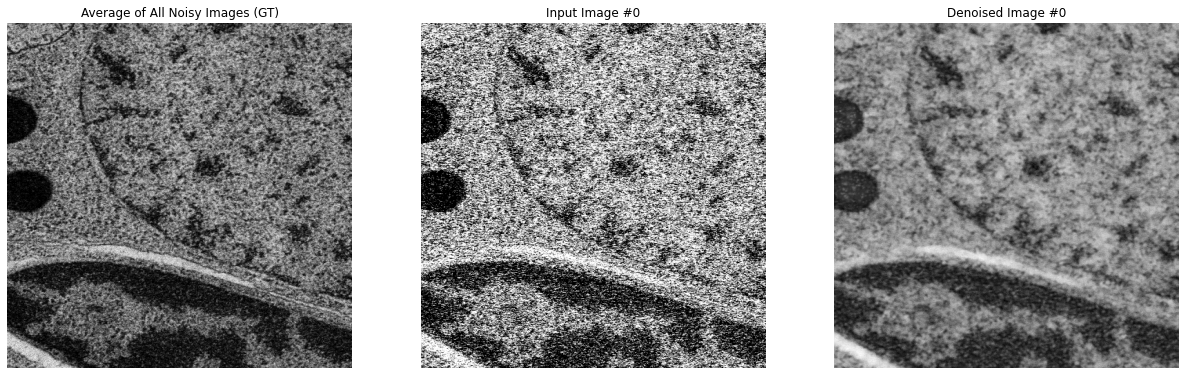

In [23]:
idx=0
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
plt.imshow(gt[1000:1500,400:900], cmap='gray_r')
plt.axis('off');
plt.title('Average of All Noisy Images (GT)')
plt.subplot(1,3,2)
plt.imshow(test_imgs[idx][1000:1500,400:900], cmap='gray_r')
plt.axis('off');
plt.title('Input Image #{}'.format(idx));
plt.subplot(1,3,3)
plt.imshow(test_denoised[idx][1000:1500,400:900], cmap='gray_r')
plt.axis('off');
plt.title('Denoised Image #{}'.format(idx));

In [24]:
def PSNR(gt, img):
    mse = np.mean((gt - img)**2)
    r = np.max(gt) - np.min(gt)
    return 20*np.log10(r) - 10*np.log10(mse)

In [25]:
# With a GT image we can compute PSNR values. 
for i in range(test_imgs.shape[0]):
    psnr_input = PSNR(gt, test_imgs[i])
    psnr_denoised = PSNR(gt, test_denoised[i])
    
    print('PSNR Input: {}; PSNR Denoised: {}'.format(np.round(psnr_input,2), np.round(psnr_denoised,2)))

PSNR Input: 10.02; PSNR Denoised: 17.72
PSNR Input: 12.95; PSNR Denoised: 18.74
PSNR Input: 13.46; PSNR Denoised: 19.07
PSNR Input: 12.54; PSNR Denoised: 19.39
PSNR Input: 13.76; PSNR Denoised: 20.04
PSNR Input: 14.65; PSNR Denoised: 20.59
PSNR Input: 18.49; PSNR Denoised: 21.27
